# Build a binary classifier
### With a feature function drawn from a normal distribution

**Name: Dahye Kim (김다혜)**  
**ID: 20153712**  
**Date: 29 November 2018**  
**Project Github:** https://github.com/joyfuldahye/MFCVML_Assignments/tree/master/Assignment09  

**Requirements** 

* Define a linear bi-partitioning function $\tilde{f}$ to classify digit ’0’ against all the other digits ’1’, ’2’, ’3’, ’4’, ’5’, ’6’, ’7’, ’8’, ’9’ using the training data at MNIST dataset
* Define the classifier $\hat{f}(x) = sign(\tilde{f}(x))$ using the sign function:

$sign(x) =   \begin{cases}
    +1       & \quad \text{if } x \geq0\\
    -1  & \quad \text{if } x \text{ < 0}
  \end{cases}$

* Evaluate the performance of the classifier $\hat{f}$ using the testing data at MNIST dataset based on TP(True Positive), FP(False Positive), TN(True Negative) and FN(False Negative)

* Let $x = (x_1, x_2, ..., x_{784})$ be a vector that represent an image of the size 28 x 28
* Let $f_i$ be a feature function such that $f_i:\mathbb{R}^{784} \to \mathbb{R}:$  
$f_i(x) = r_i^{T}x, \space r_i \sim N(0,\sigma),\space r_i \in \mathbb{R}^{784}$  
  where $r_i$ denotes a random vector drawn from a normal distribution. (function: numpy.random.normal)
* The partitioning function $\tilde{f}: \mathbb{R}^{784} \to \mathbb{R}$ is defined by:  
$\tilde{f}(x;\theta)=\theta_1f_1(x)+\theta_2f_2(x)+...+\theta_{p}f_{p}(x)$ 
    where $\theta = (\theta_1, \theta_2,...,\theta_{p})$ denotes the model parameters

**Essential Visualisation**

* Try with varying the number of parameters $p$ with the standard deviation $\sigma = 1$ of the random feature vector $r$
* Present the best $F_1$ score among the results with different number of parameters $p$  
  * $F_1$ score $= 2 * \frac{precision*recall}{precision+recall}$
  * Precision $= \frac{True positive}{All positive}$
  * Recall $= \frac{True positive}{True positive + False negative}$
* Plot the average image (28 x 28) of True Positive
* Plot the average image (28 x 28) of False Positive
* Plot the average image (28 x 28) of True Negative
* Plot the average image (28 x 28) of False Negative

-----------------------------------------------------------------------

## Import libraries and define variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

## Define data loader class for MNIST  
* **generate_feature_functions**
  * feature function $f_i:\mathbb{R}^{784} \to \mathbb{R}:$  
$f_i(x) = r_i^{T}x, \space r_i \sim N(0,\sigma),\space r_i \in \mathbb{R}^{784}$  
  where $r_i$ denotes a random vector drawn from a normal distribution. (function: numpy.random.normal)

In [2]:
# mnist data loader
class MnistDataLoader(object):
    def __init__(self, file_data_train, file_data_test, num_parameters, mu, sigma, size_row=28, size_col=28):
        h_data_train    = open(file_data_train, "r")
        h_data_test     = open(file_data_test, "r")
        
        # raw data
        self.data_train = h_data_train.readlines()
        self.data_test = h_data_test.readlines()
        self.num_train   = len(self.data_train)   # number of training images
        self.num_test    = len(self.data_test)    # number of testing images
        h_data_train.close()
        h_data_test.close()
        
        # info data 
        self.size_row = size_row
        self.size_col = size_col
        self.data_length = self.size_row * self.size_col
        
        # preprocessing data
        self.list_image_train    = np.empty((self.size_row * self.size_col, self.num_train), dtype=float)
        self.list_label_train    = np.empty(self.num_train, dtype=int)

        self.list_image_test     = np.empty((self.size_row * self.size_col, self.num_test), dtype=float)
        self.list_label_test     = np.empty(self.num_test, dtype=int)
        
        self.preprocess_data()
        
        # set parameters
        self.p = num_parameters
        self.mu = mu
        self.sigma = sigma
        
        # set feature vectors
        self.generate_feature_vectors()
        
        # init prediction result
        self.prediction = 0
        

    def normalize(self, data):
        data_normalized = (data - min(data)) / (max(data) - min(data))
        return(data_normalized)
        
    def preprocess_data(self):
        for count, line in enumerate(self.data_train):
            line_data   = line.split(',')
            label       = line_data[0]
            im_vector   = np.asfarray(line_data[1:])
            im_vector   = self.normalize(im_vector)

            self.list_label_train[count]     = label
            self.list_image_train[:, count]  = im_vector    

        for count, line in enumerate(self.data_test):
            line_data   = line.split(',')
            label       = line_data[0]
            im_vector   = np.asfarray(line_data[1:])
            im_vector   = self.normalize(im_vector)

            self.list_label_test[count]      = label
            self.list_image_test[:, count]   = im_vector   
            
    # generate basis functions with varing p
    def generate_feature_vectors(self):
        self.basis_functions = np.zeros((self.data_length, self.p), dtype=float)
        self.feature_vectors = np.zeros((self.p, self.num_train), dtype=float)
        for i in range(self.p):
            random_normal_vector = np.random.normal(self.mu, self.sigma, self.data_length)
            self.basis_functions[:,i] = random_normal_vector
        for data in range(self.num_train):
            for p in range(self.p):
                self.feature_vectors[p, data] = np.sum(self.basis_functions[:, p] * self.list_image_train[:, data])
                
#     def generate_basis_functions(self):
#         self.basis_functions = np.zeros((self.data_length, self.p), dtype=float)
#         for i in range(self.p):
#             random_normal_vector = np.random.normal(self.mu, self.sigma, self.data_length)
#             self.basis_functions[:,i] = random_normal_vector

## Define a bi-classifier class to detect '0' with sign function


* **Initialisation**
  * set learning rate
  * randomly initailse the first model parameters

* **Predict with sign function**
  * $sign(x) =   \begin{cases}
    +1       & \quad \text{if } x \geq0\\
    -1  & \quad \text{if } x \text{ < 0}
  \end{cases}$
* **Update model parameters**
  * $\theta_p =   \begin{cases}
    \theta_p + (1 * \alpha * x_i)       & \quad \text{if } \hat{f}(x) = -1 but\space y = 1 \
    \\
     \theta_p + (-1 * \alpha * x_i)  & \quad \text{if }  \hat{f}(x) = 1 but\space y = -1
  \end{cases}$
    * where $\alpha = learning\space rate$
    * where $x_i = r_p^{T}x_j$

In [3]:
# classifier using sign function
class BinaryClassifier(object):
    def __init__(self, data_loader, learning_rate):
        self.data_loader = data_loader
        
        self.num_parameter = self.data_loader.p
        self.learning_rate = learning_rate
        self.basis_functions = self.data_loader.basis_functions
        # init the model parameters (randomly)
        self.model_parameters = np.random.uniform(-1, 1, self.num_parameter)
        self.list_updated_model_parameters = [self.model_parameters]

    def predict(self, x):
        if np.sum(x * self.model_parameters) >= 0:
            return 1
        else:
            return -1

    def update_model_parameters(self, x, y):
        if self.predict(x) != y: # if prediction is false
#         if self.data_loader.prediction != y: # if prediction is false
            if y == 1: # when false negative
                for j in range(self.data_loader.p):
                    change = (1 * self.learning_rate * x[j])
                    new_parameter = (self.model_parameters[j] + change)
                    self.model_parameters[j] = new_parameter
            else: # when false positive
                for j in range(self.data_loader.p):
                    change = (-1 * self.learning_rate * x[j])
                    new_parameter = self.model_parameters[j] + change
                    self.model_parameters[j] = new_parameter
        else:
            self.model_parameters = self.model_parameters
        self.list_updated_model_parameters.append(self.model_parameters)

## Define a trainer class with sign function  
* **Initialisation**  
  * Assign new labels to train and test images $if\space0 \to 1,$ $if \space not\space 0 \to -1$
* **Train**  
  * Execute prediction and update model parameters as much as given epoch

In [4]:
class TrainerWithSign(object):
    def __init__(self, classifier, data_loader):
        self.classifier = classifier
        self.data_loader = deepcopy(data_loader)
        self.prediction_result_train = []
        
        # change train label 
        for i, train_label in enumerate(self.data_loader.list_label_train):
            if train_label == 0:
                self.data_loader.list_label_train[i] = 1
            else:
                self.data_loader.list_label_train[i] = -1
        
        # change test label
        for i, test_label in enumerate(self.data_loader.list_label_test):
            if test_label == 0:
                self.data_loader.list_label_test[i] = 1
            else:
                self.data_loader.list_label_test[i] = -1
        
        
    def train(self, num_epoch):
        for e in range(num_epoch):
            self.prediction_result_train = []
            num_collect = 0
            for i in range(self.data_loader.num_train):
                x = self.data_loader.feature_vectors[:, i]
                y = self.data_loader.list_label_train[i]
                self.data_loader.prediction = self.classifier.predict(x)
                self.prediction_result_train.append(self.data_loader.prediction)
                
                if y == self.data_loader.prediction:
                    num_collect += 1
                
                self.classifier.update_model_parameters(x, y)
        # original
#             print('Epoch=%d, Accuracy=%.6f' % (e, num_collect / self.data_loader.num_train))
#             param_row = np.sqrt(self.data_loader.p)
#             param_col = np.sqrt(self.data_loader.p)
#             self.classifier.plot_parameters(e, int(param_row), int(param_col))
            print('Epoch=%d, Accuracy=%.6f' % (e, num_collect / self.data_loader.num_train))


## Define a polt and analyse class

In [5]:
class PlotterAndAnalyser(object):
    def __init__(self, data_loader, classifier, trainer):
        self.data_loader = data_loader
        self.classifier = classifier
        self.trainer = trainer
        
        self.param_row = int(np.sqrt(self.classifier.num_parameter))
        self.param_col = int(np.sqrt(self.classifier.num_parameter))
        
        # initialise vectors for result images
        self.im_average  = np.zeros((self.data_loader.size_row * self.data_loader.size_col, 4), dtype=float)
        self.im_count    = np.zeros(4, dtype=int)
    

    def plot_parameters(self, epoch):
        plt.figure(figsize=(16,16))
        for e in range(epoch):
            self.parameters_image = np.asarray(self.classifier.list_updated_model_parameters[e])
            
            plt.subplot((epoch/5), 5, e+1)
            plt.title(f'Epoch{e}: model Parameters')
            plt.imshow(self.parameters_image.reshape((self.param_row, self.param_col)), 
                       cmap='Greys',
                       interpolation='None')
            frame   = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
        plt.show()

    def plot_classified_result(self, num_data, list_label_data, partition_result, list_image_data):
        for i in range(num_data):
            if list_label_data[i] == 1 and partition_result[i] == 1: # true positive
                self.im_average[:, 0] += list_image_data[:, i]
                self.im_count[0] += 1
            elif list_label_data[i] == -1 and partition_result[i] == -1: # true negative
                self.im_average[:, 1] += list_image_data[:, i]
                self.im_count[1] += 1
            elif list_label_data[i] == -1 and partition_result[i] == 1: # false positive
                self.im_average[:, 2] += list_image_data[:, i]
                self.im_count[2] += 1
            elif list_label_data[i] == 1 and partition_result[i] == -1: # false negative
                self.im_average[:, 3] += list_image_data[:, i]
                self.im_count[3] += 1

        titles = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
        plt.figure(figsize=(4,4))

        for i in range(4):

            self.im_average[:, i] /= self.im_count[i]

            plt.subplot(2, 2, i+1)
            plt.title(titles[i])
            plt.imshow(self.im_average[:,i].reshape((self.data_loader.size_row, self.data_loader.size_col)), cmap='Greys', interpolation='None') 

            frame   = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
        plt.show()
    
    def plot_evaluation_table(self):
        column_list = ['Positive', 'Negative', 'Total']
        row_list = ['True', 'False', 'All']
        self.num_true_positive =  self.im_count[0]
        self.num_true_negative =  self.im_count[1]
        self.num_false_positive =  self.im_count[2]
        self.num_false_negative =  self.im_count[3]
        self.total_positive = self.num_true_positive + self.num_false_positive
        self.total_negative = self.num_true_negative + self.num_false_negative
        self.total_true =  self.num_true_positive + self.num_true_negative
        self.total_false = self.num_false_positive + self.num_false_negative
        self.total_all = self.total_true + self.total_false
        self.total = [self.total_true, self.total_false, self.total_all]
        self.positives = [self.num_true_positive, self.num_false_positive, self.total_positive]
        self.negatives = [self.num_true_negative, self.num_false_negative, self.total_negative]

        evaluation_table = pd.DataFrame({'positive': self.positives,
                          'negative': self.negatives,
                          'Total': self.total})
        evaluation_table.rename(index={0:'True', 1:'False', 2:'All'}, inplace=True)
        return evaluation_table
    
    def plot_scores(self):
        column_list = ['Precision', 'Recall', 'F1 score']
        self.precision = self.num_true_positive / (self.num_true_positive + self.num_false_positive)
        self.recall = self.num_true_positive / (self.num_true_positive + self.num_false_negative)
        self.f1_score = 2 * (self.precision*self.recall / (self.precision + self.recall))
        
        scores = pd.Series({'Precision': self.precision, 'Recall': self.recall, 'F1 score': self.f1_score})
        return scores
    

## Execute train with training data
* set learning rate = 0.0001
* start from $p = 2^4$
* epoch: 20

In [6]:
# keep instances with varing p
exponents = []
data_loaders = []
classifiers = []
trainers = []

### Train With $p = 2^4$

In [7]:
mnist_data_loader_ex4 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**4, 0, 1)

In [8]:
binary_classifier_ex4 = BinaryClassifier(mnist_data_loader_ex4, 0.0001)
trainer_ex4 = TrainerWithSign(binary_classifier_ex4, mnist_data_loader_ex4)
trainer_ex4.train(20)

Epoch=0, Accuracy=0.903067
Epoch=1, Accuracy=0.905000
Epoch=2, Accuracy=0.906500
Epoch=3, Accuracy=0.906233
Epoch=4, Accuracy=0.905800
Epoch=5, Accuracy=0.905417
Epoch=6, Accuracy=0.905950
Epoch=7, Accuracy=0.905083
Epoch=8, Accuracy=0.906000
Epoch=9, Accuracy=0.906000
Epoch=10, Accuracy=0.906900
Epoch=11, Accuracy=0.905567
Epoch=12, Accuracy=0.905800
Epoch=13, Accuracy=0.905950
Epoch=14, Accuracy=0.905833
Epoch=15, Accuracy=0.907367
Epoch=16, Accuracy=0.906117
Epoch=17, Accuracy=0.905217
Epoch=18, Accuracy=0.906400
Epoch=19, Accuracy=0.907017


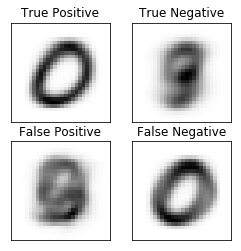

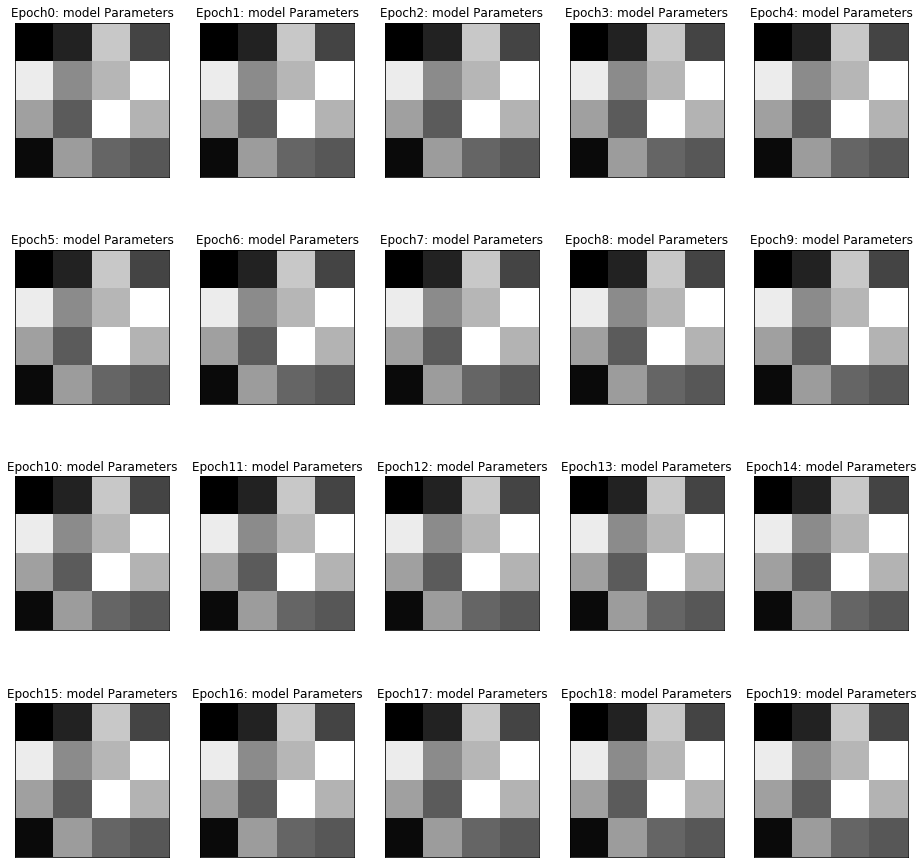

       positive  negative  Total
True       3448     50973  54421
False      3104      2475   5579
All        6552     53448  60000
Precision    0.526252
Recall       0.582137
F1 score     0.552786
dtype: float64


In [9]:
plotter_and_analyser_ex4 = PlotterAndAnalyser(mnist_data_loader_ex4, binary_classifier_ex4, trainer_ex4)
plotter_and_analyser_ex4.plot_classified_result(mnist_data_loader_ex4.num_train,
                                            trainer_ex4.data_loader.list_label_train,
                                           trainer_ex4.prediction_result_train,
                                           mnist_data_loader_ex4.list_image_train)
plotter_and_analyser_ex4.plot_parameters(20)
print(plotter_and_analyser_ex4.plot_evaluation_table())
print(plotter_and_analyser_ex4.plot_scores())

In [10]:
exponents.append(2**4)
data_loaders.append(mnist_data_loader_ex4)
classifiers.append(binary_classifier_ex4)
trainers.append(trainer_ex4)

### Train with $p = 2^6$

In [11]:
# load data
mnist_data_loader_ex6 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**6, 0, 1)

In [12]:
# set classifier
binary_classifier_ex6 = BinaryClassifier(mnist_data_loader_ex6, 0.0001)

In [13]:
# train
trainer_ex6 = TrainerWithSign(binary_classifier_ex6, mnist_data_loader_ex6)
trainer_ex6.train(20)

Epoch=0, Accuracy=0.928900
Epoch=1, Accuracy=0.962600
Epoch=2, Accuracy=0.966267
Epoch=3, Accuracy=0.967733
Epoch=4, Accuracy=0.968350
Epoch=5, Accuracy=0.968550
Epoch=6, Accuracy=0.968400
Epoch=7, Accuracy=0.965383
Epoch=8, Accuracy=0.963833
Epoch=9, Accuracy=0.963517
Epoch=10, Accuracy=0.963617
Epoch=11, Accuracy=0.964350
Epoch=12, Accuracy=0.963933
Epoch=13, Accuracy=0.964050
Epoch=14, Accuracy=0.963950
Epoch=15, Accuracy=0.964017
Epoch=16, Accuracy=0.963983
Epoch=17, Accuracy=0.963433
Epoch=18, Accuracy=0.963717
Epoch=19, Accuracy=0.963367


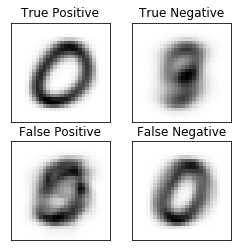

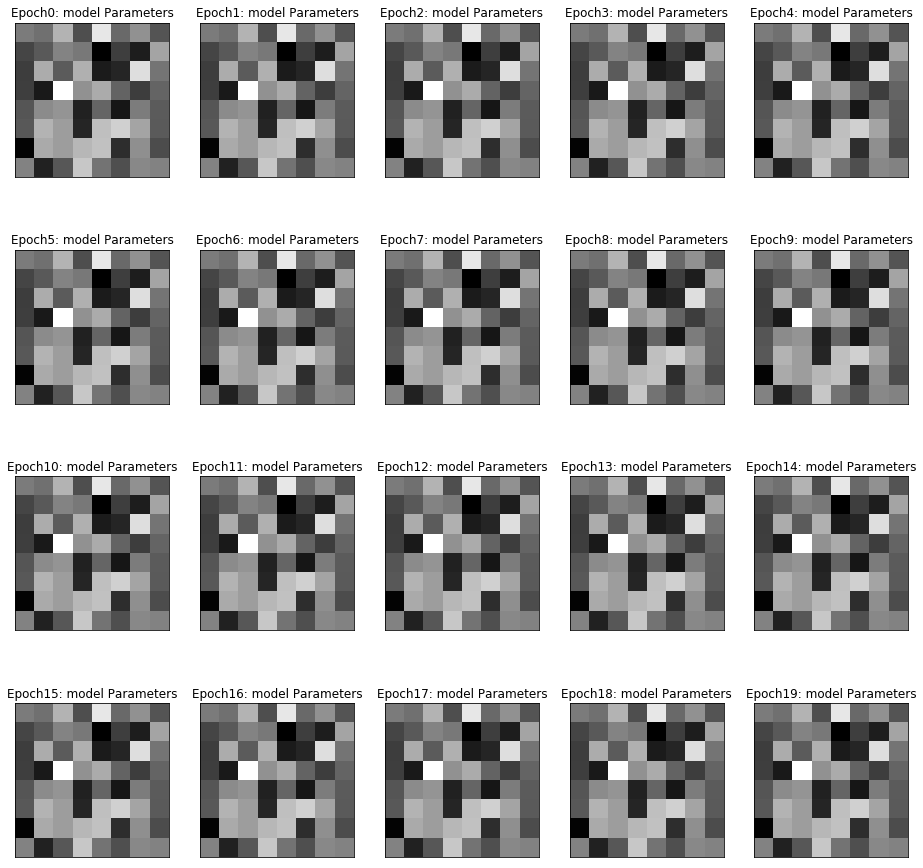

       positive  negative  Total
True       4996     52806  57802
False      1271       927   2198
All        6267     53733  60000
Precision    0.797192
Recall       0.843491
F1 score     0.819688
dtype: float64


In [14]:
# plot
plotter_and_analyser_ex6 = PlotterAndAnalyser(mnist_data_loader_ex6, binary_classifier_ex6, trainer_ex6)
plotter_and_analyser_ex6.plot_classified_result(mnist_data_loader_ex6.num_train,
                                            trainer_ex6.data_loader.list_label_train,
                                           trainer_ex6.prediction_result_train,
                                           mnist_data_loader_ex6.list_image_train)
plotter_and_analyser_ex6.plot_parameters(20)
print(plotter_and_analyser_ex6.plot_evaluation_table())
print(plotter_and_analyser_ex6.plot_scores())

In [15]:
# append result
exponents.append(2**6)
data_loaders.append(mnist_data_loader_ex6)
classifiers.append(binary_classifier_ex6)
trainers.append(trainer_ex6)

### Train with $p = 2^8$

In [16]:
# load data
mnist_data_loader_ex8 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**8, 0, 1)

In [17]:
# set classifier
binary_classifier_ex8 = BinaryClassifier(mnist_data_loader_ex8, 0.0001)

In [18]:
# train
trainer_ex8 = TrainerWithSign(binary_classifier_ex8, mnist_data_loader_ex8)
trainer_ex8.train(20)

Epoch=0, Accuracy=0.958283
Epoch=1, Accuracy=0.979033
Epoch=2, Accuracy=0.981583
Epoch=3, Accuracy=0.982233
Epoch=4, Accuracy=0.982833
Epoch=5, Accuracy=0.983067
Epoch=6, Accuracy=0.983283
Epoch=7, Accuracy=0.983567
Epoch=8, Accuracy=0.983667
Epoch=9, Accuracy=0.983833
Epoch=10, Accuracy=0.984017
Epoch=11, Accuracy=0.984150
Epoch=12, Accuracy=0.984417
Epoch=13, Accuracy=0.984617
Epoch=14, Accuracy=0.984667
Epoch=15, Accuracy=0.984633
Epoch=16, Accuracy=0.984800
Epoch=17, Accuracy=0.984783
Epoch=18, Accuracy=0.984883
Epoch=19, Accuracy=0.984950


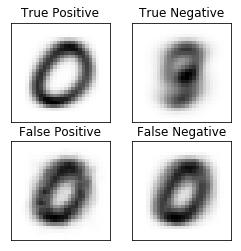

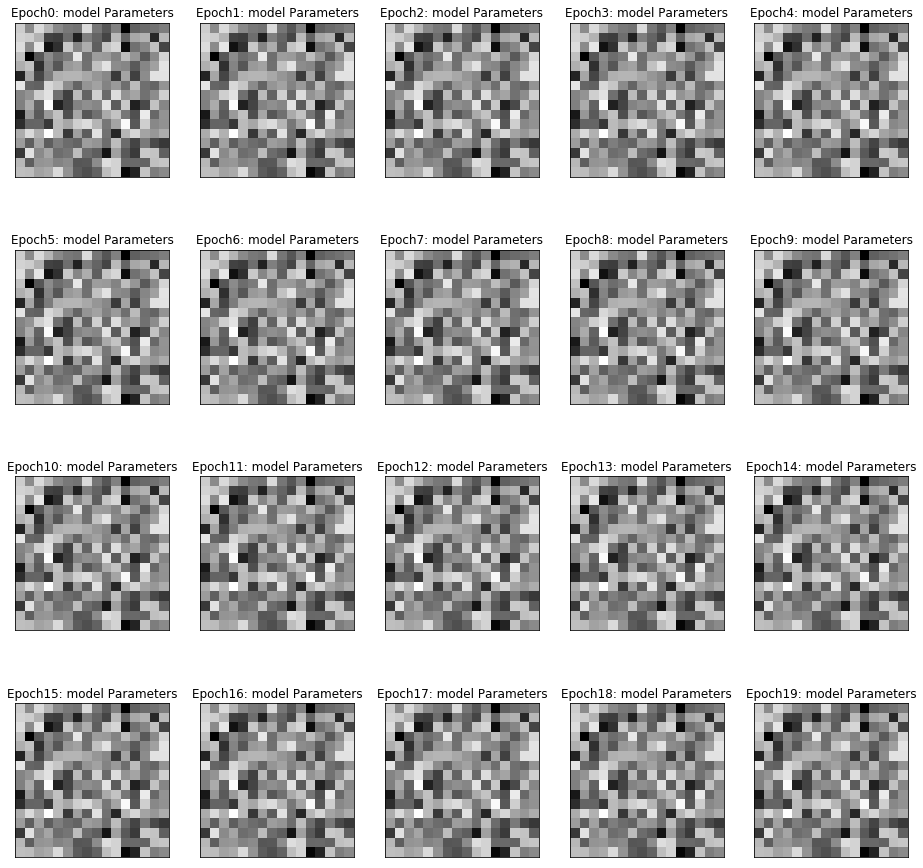

       positive  negative  Total
True       5540     53557  59097
False       520       383    903
All        6060     53940  60000
Precision    0.914191
Recall       0.935337
F1 score     0.924643
dtype: float64


In [19]:
# plot
plotter_and_analyser_ex8 = PlotterAndAnalyser(mnist_data_loader_ex8, binary_classifier_ex8, trainer_ex8)
plotter_and_analyser_ex8.plot_classified_result(mnist_data_loader_ex8.num_train,
                                            trainer_ex8.data_loader.list_label_train,
                                           trainer_ex8.prediction_result_train,
                                           mnist_data_loader_ex8.list_image_train)
plotter_and_analyser_ex8.plot_parameters(20)
print(plotter_and_analyser_ex8.plot_evaluation_table())
print(plotter_and_analyser_ex8.plot_scores())

In [20]:
# append result
exponents.append(2**8)
data_loaders.append(mnist_data_loader_ex8)
classifiers.append(binary_classifier_ex8)
trainers.append(trainer_ex8)

### Train with $p = 2^{10}$

In [21]:
# load data
mnist_data_loader_ex10 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**10, 0, 1)

In [22]:
# set classifier
binary_classifier_ex10 = BinaryClassifier(mnist_data_loader_ex10, 0.0001)

In [23]:
# train
trainer_ex10 = TrainerWithSign(binary_classifier_ex10, mnist_data_loader_ex10)
trainer_ex10.train(20)

Epoch=0, Accuracy=0.963517
Epoch=1, Accuracy=0.980417
Epoch=2, Accuracy=0.983033
Epoch=3, Accuracy=0.984183
Epoch=4, Accuracy=0.984717
Epoch=5, Accuracy=0.985067
Epoch=6, Accuracy=0.985117
Epoch=7, Accuracy=0.985250
Epoch=8, Accuracy=0.985617
Epoch=9, Accuracy=0.985717
Epoch=10, Accuracy=0.985933
Epoch=11, Accuracy=0.986033
Epoch=12, Accuracy=0.986250
Epoch=13, Accuracy=0.986183
Epoch=14, Accuracy=0.986317
Epoch=15, Accuracy=0.986350
Epoch=16, Accuracy=0.986667
Epoch=17, Accuracy=0.986233
Epoch=18, Accuracy=0.986650
Epoch=19, Accuracy=0.986733


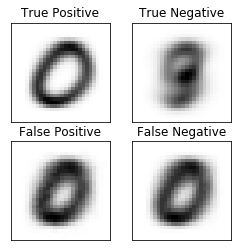

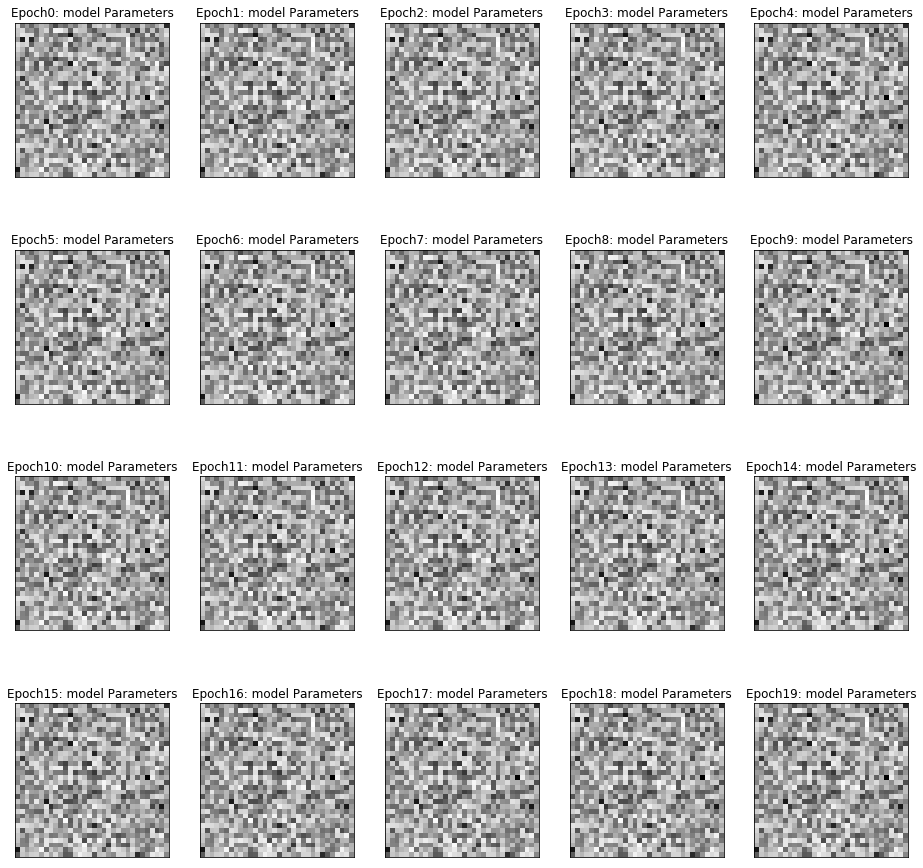

       positive  negative  Total
True       5582     53622  59204
False       455       341    796
All        6037     53963  60000
Precision    0.924631
Recall       0.942428
F1 score     0.933445
dtype: float64


In [24]:
# plot
plotter_and_analyser_ex10 = PlotterAndAnalyser(mnist_data_loader_ex10, binary_classifier_ex10, trainer_ex10)
plotter_and_analyser_ex10.plot_classified_result(mnist_data_loader_ex10.num_train,
                                            trainer_ex10.data_loader.list_label_train,
                                           trainer_ex10.prediction_result_train,
                                           mnist_data_loader_ex10.list_image_train)
plotter_and_analyser_ex10.plot_parameters(20)
print(plotter_and_analyser_ex10.plot_evaluation_table())
print(plotter_and_analyser_ex10.plot_scores())

In [25]:
# append result
exponents.append(2**10)
data_loaders.append(mnist_data_loader_ex10)
classifiers.append(binary_classifier_ex10)
trainers.append(trainer_ex10)

### Train with $p = 2^{12}$

In [26]:
# load data
mnist_data_loader_ex12 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**12, 0, 1)

In [27]:
# set classifier
binary_classifier_ex12 = BinaryClassifier(mnist_data_loader_ex12, 0.0001)

In [28]:
# train
trainer_ex12 = TrainerWithSign(binary_classifier_ex12, mnist_data_loader_ex12)
trainer_ex12.train(20)

Epoch=0, Accuracy=0.971883
Epoch=1, Accuracy=0.982900
Epoch=2, Accuracy=0.984483
Epoch=3, Accuracy=0.985533
Epoch=4, Accuracy=0.986133
Epoch=5, Accuracy=0.986433
Epoch=6, Accuracy=0.986400
Epoch=7, Accuracy=0.986700
Epoch=8, Accuracy=0.987217
Epoch=9, Accuracy=0.987167
Epoch=10, Accuracy=0.987450
Epoch=11, Accuracy=0.987333
Epoch=12, Accuracy=0.987633
Epoch=13, Accuracy=0.987900
Epoch=14, Accuracy=0.987733
Epoch=15, Accuracy=0.988183
Epoch=16, Accuracy=0.987883
Epoch=17, Accuracy=0.988500
Epoch=18, Accuracy=0.987917
Epoch=19, Accuracy=0.988250


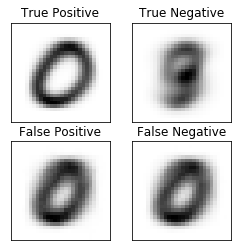

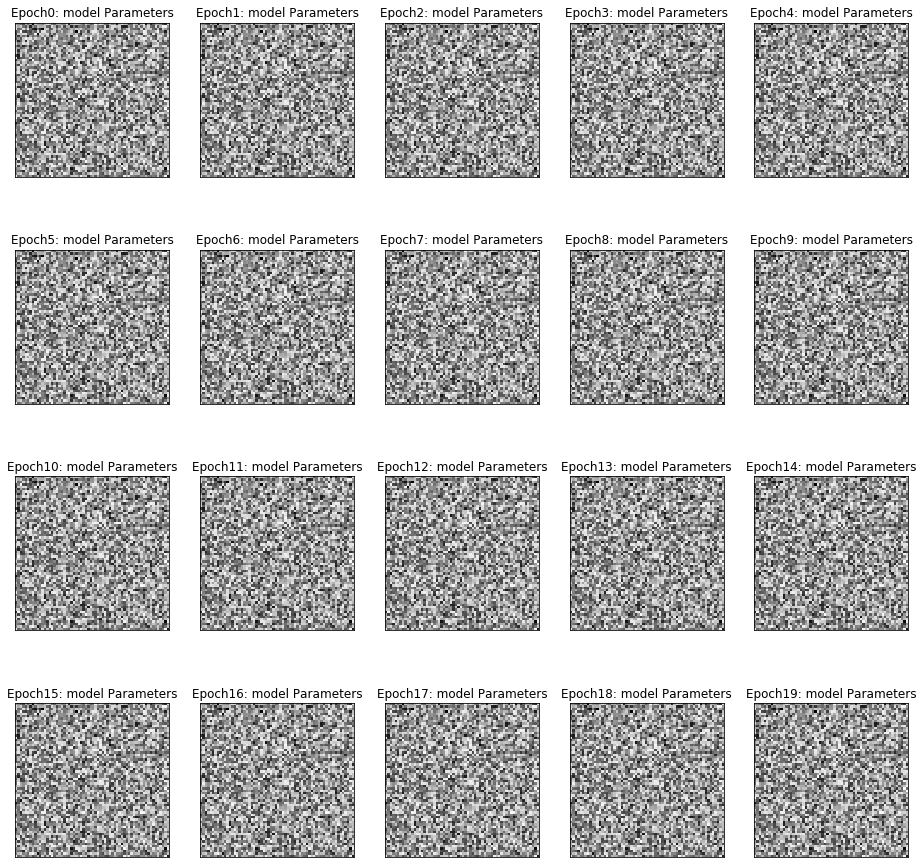

       positive  negative  Total
True       5610     53685  59295
False       392       313    705
All        6002     53998  60000
Precision    0.934688
Recall       0.947155
F1 score     0.940881
dtype: float64


In [29]:
# plot
plotter_and_analyser_ex12 = PlotterAndAnalyser(mnist_data_loader_ex12, binary_classifier_ex12, trainer_ex12)
plotter_and_analyser_ex12.plot_classified_result(mnist_data_loader_ex12.num_train,
                                            trainer_ex12.data_loader.list_label_train,
                                           trainer_ex12.prediction_result_train,
                                           mnist_data_loader_ex12.list_image_train)
plotter_and_analyser_ex12.plot_parameters(20)
print(plotter_and_analyser_ex12.plot_evaluation_table())
print(plotter_and_analyser_ex12.plot_scores())

In [30]:
# append result
exponents.append(2**12)
data_loaders.append(mnist_data_loader_ex12)
classifiers.append(binary_classifier_ex12)
trainers.append(trainer_ex12)

## Summary of training

In [35]:
F1_list = [plotter_and_analyser_ex4.f1_score,
           plotter_and_analyser_ex6.f1_score,
          plotter_and_analyser_ex8.f1_score,
          plotter_and_analyser_ex10.f1_score,
          plotter_and_analyser_ex12.f1_score]
str_exponents = list(map(str,exponents))

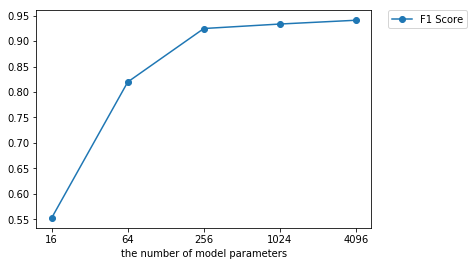

In [53]:
fig, ax = plt.subplots()
ax.plot(str_exponents, F1_list, marker='o', label="F1 Score")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('the number of model parameters')

plt.show()

> As the number of model parameters increases, the F1 score becomes higher meaning that when the number for model parameters is larger, the model detects '0' better. However, we are not sure if the number gets too higher, how the result of F1 score will look. Therefore, furture experiments with the higher number of model parameters are need to be executed to check the performance.

# Run the result model parameters with test data

In [31]:
def test(mnist_data_loader, binary_classifier, trainer):
    test_model_parameters = binary_classifier.model_parameters
    test_num_parameter = mnist_data_loader.p

    # generate feature vectors for test
    test_basis_functions = mnist_data_loader.basis_functions
    test_feature_vectors = np.zeros((test_num_parameter, mnist_data_loader.num_test), dtype=float)
    for data in range(mnist_data_loader.num_test):
        for p in range(test_num_parameter):
            test_feature_vectors[p, data] = np.sum(test_basis_functions[:, p] * mnist_data_loader.list_image_test[:, data])

    prediction_result_test = []
    new_test_label = trainer.data_loader.list_label_test
    test_image = mnist_data_loader.list_image_test
    test_length = mnist_data_loader.num_test

    for t in range(test_length):
        if np.sum(test_feature_vectors[:,t] * test_model_parameters) >= 0:
            prediction_result_test.append(1)
        else:
            prediction_result_test.append(-1)


    # plot
    plotter_and_analyser_test = PlotterAndAnalyser(mnist_data_loader, binary_classifier, trainer)
    plotter_and_analyser_test.plot_classified_result(test_length,
                                                     new_test_label,
                                                     prediction_result_test,
                                                    test_image)
    print(plotter_and_analyser_test.plot_evaluation_table())
    print("                       ")
    print("*****Score Summary*****")
    print(plotter_and_analyser_test.plot_scores())


*********TEST with p=16*********


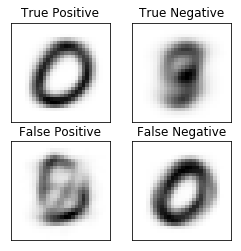

       positive  negative  Total
True        585      8715   9300
False       305       395    700
All         890      9110  10000
                       
*****Score Summary*****
Precision    0.657303
Recall       0.596939
F1 score     0.625668
dtype: float64
*********TEST with p=64*********


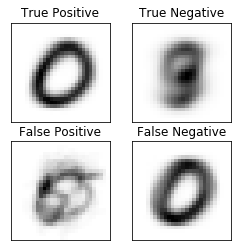

       positive  negative  Total
True        566      8976   9542
False        44       414    458
All         610      9390  10000
                       
*****Score Summary*****
Precision    0.927869
Recall       0.577551
F1 score     0.711950
dtype: float64
*********TEST with p=256*********


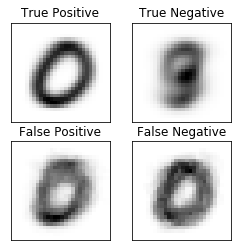

       positive  negative  Total
True        939      8926   9865
False        94        41    135
All        1033      8967  10000
                       
*****Score Summary*****
Precision    0.909003
Recall       0.958163
F1 score     0.932936
dtype: float64
*********TEST with p=1024*********


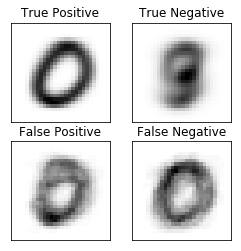

       positive  negative  Total
True        947      8957   9904
False        63        33     96
All        1010      8990  10000
                       
*****Score Summary*****
Precision    0.937624
Recall       0.966327
F1 score     0.951759
dtype: float64
*********TEST with p=4096*********


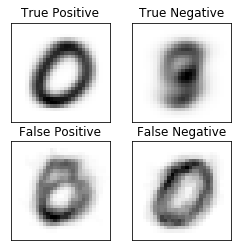

       positive  negative  Total
True        937      8952   9889
False        68        43    111
All        1005      8995  10000
                       
*****Score Summary*****
Precision    0.932338
Recall       0.956122
F1 score     0.944081
dtype: float64


In [33]:
for i in range(5):
    print(f"*********TEST with p={exponents[i]}*********")
    test(data_loaders[i], classifiers[i], trainers[i])

> Like the result of training data, testing data also proves that as the number of model parameters increases, the F1 score becomes higher meaning that when the number for model parameters is larger, the model detects '0' better. However, we are not sure if the number gets too higher, how the result of F1 score will look. Therefore, furture experiments with the higher number of model parameters are need to be executed to check the performance.